In [1]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

from tf_agents.agents.dqn import dqn_agent
from tf_agents.environments import tf_py_environment
from tf_agents.networks import sequential
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common
from tf_agents.specs import tensor_spec, from_spec
from tf_agents import trajectories

# from env.PyEnvironments import CurveEnv, CurveMultipleEnv, JVMEnv
# from env.PyEnvironments import JVMEnv
from env.PyEnvironmentsTest import JVMEnv # !!!

In [2]:
TEST_JDK_PATH = "/Users/ellkrauze/projects/gc-ml/jdk-11.0.20.1.jdk"
BM = "avrora"
BM_TEST = "kafka"
BM_PATH = "/Users/ellkrauze/projects/gc-ml/dacapo-bench.jar"
CALLBACK_PATH = "/home/vsakovskaya/gc-ml/dacapo/DacapoCallback/DacapoChopin/VMStatCallback.java"
dataset_path = "dataset/data"
tempdir = "tmp"
checkpoint_dir = os.path.join(tempdir, 'checkpoint')
policy_dir = os.path.join(tempdir, 'policy')

env = JVMEnv(jdk=TEST_JDK_PATH, bm_path=BM_PATH, 
    callback_path=CALLBACK_PATH, bm=BM, verbose=True)

env_test = JVMEnv(jdk=TEST_JDK_PATH, bm_path=BM_PATH, 
        callback_path=CALLBACK_PATH, bm=BM_TEST, verbose=True)

train_env = tf_py_environment.TFPyEnvironment(env, isolation=True)
eval_env = tf_py_environment.TFPyEnvironment(env, isolation=True)
test_env = tf_py_environment.TFPyEnvironment(env_test)

action_spec = from_spec(train_env.action_spec())
observation_spec = from_spec(train_env.observation_spec())
reward_spec = from_spec(train_env.reward_spec())
time_step_spec = trajectories.time_step_spec(observation_spec, reward_spec)

Successfully initialized a JVM Environment!
 JDK: /Users/ellkrauze/projects/gc-ml/jdk-11.0.20.1.jdk/bin,
 Benchmark: avrora (/Users/ellkrauze/projects/gc-ml/dacapo-bench.jar),
 Number of iterations: 5,
 Goal: avgGCPause,
 Number of JVM options: 2,
 JVM options: {'MaxTenuringThreshold': {'min': 1, 'max': 16}, 'ParallelGCThreads': {'min': 4, 'max': 24}},
 Env. default state: [list([7, 12]) 0.47],
 Env. default goal value: 0.47,

Successfully initialized a JVM Environment!
 JDK: /Users/ellkrauze/projects/gc-ml/jdk-11.0.20.1.jdk/bin,
 Benchmark: kafka (/Users/ellkrauze/projects/gc-ml/dacapo-bench.jar),
 Number of iterations: 5,
 Goal: avgGCPause,
 Number of JVM options: 2,
 JVM options: {'MaxTenuringThreshold': {'min': 1, 'max': 16}, 'ParallelGCThreads': {'min': 4, 'max': 24}},
 Env. default state: [list([7, 12]) 0.34],
 Env. default goal value: 0.34,



### WandB

In [3]:
! export WANDB_NOTEBOOK_NAME="main.ipynb"
import wandb

PROJECT_NAME = "Reinforcement Learning (DQN) - JVM-GC"
WANDB_KEY = "4b077df3688052b0f43705d6b4d712c05fb979b7"
config = dict(
    competition = PROJECT_NAME,
    _wandb_kernel = 'lemon',
    seed = 42,
)

In [14]:
def get_q_net(action_spec, fc_layer_params = (100, 75, 50)):
    action_tensor_spec = tensor_spec.from_spec(action_spec)
    num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

    def dense_layer(num_units):
        """
        Define a helper function to create Dense layers configured 
        with the right activation and kernel initializer.
        """
        return tf.keras.layers.Dense(
            num_units,
            activation=tf.keras.activations.relu,
            kernel_initializer=tf.keras.initializers.VarianceScaling(
                scale=2.0, mode='fan_in', distribution='truncated_normal'))

    # QNetwork consists of a sequence of Dense layers followed by a dense layer
    # with `num_actions` units to generate one q_value per available action as
    # its output.
    dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]
    q_values_layer = tf.keras.layers.Dense(
        num_actions,
        activation=None,
        kernel_initializer=tf.keras.initializers.RandomUniform(
            minval=-0.03, maxval=0.03),
        bias_initializer=tf.keras.initializers.Constant(-0.2))
    q_net = sequential.Sequential(dense_layers + [q_values_layer])
    return q_net

def collect_step(environment, policy, replay_buffer):
    time_step = environment.current_time_step()
    action_step = policy.action(time_step)

    next_time_step = environment.step(action_step.action)
    # reward = next_time_step.reward
    traj = trajectory.from_transition(time_step, action_step, next_time_step)
    return traj

def save_dataset(data, path):
    step_counter = tf.Variable(0, trainable=False)
    checkpoint_prefix = "checkpoint"
    checkpoint_args = {
        "checkpoint_interval": 50,
        "step_counter": step_counter,
        "directory": checkpoint_prefix,
        "max_to_keep": 3,
    }
    try:
        data.save(path, checkpoint_args=checkpoint_args)
    except:
        pass

def save_rb(replay_buffer, path):
    tf.train.Checkpoint(rb = replay_buffer).save(path)

def restore_rb(replay_buffer, path):
    tf.train.Checkpoint(rb = replay_buffer).restore(path)

def get_dataset(replay_buffer, size, batch_size, collect_data_spec, n_step_update, create: bool = True, save: bool = False):
    
    replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
        data_spec=collect_data_spec, # agent.collect_data_spec
        batch_size=1, # train_env.batch_size
        max_length=size) # capacity

    if create:
        for _ in tqdm(range(size)):
            traj = collect_step(train_env, random_policy, replay_buffer)
            replay_buffer.add_batch(traj)

        if save: save_rb(replay_buffer, dataset_path)
    else: 
        restore_rb(replay_buffer, dataset_path+'-1')

    dataset = replay_buffer.as_dataset(
        num_parallel_calls=3, 
        sample_batch_size=batch_size,
        num_steps=n_step_update + 1, 
        single_deterministic_pass=False).prefetch(3)
    # iterator = iter(dataset)
    return dataset
    
def compute_avg_return(environment, policy, num_episodes=50):
    """
    Computes the average return of a policy, 
    given the policy, environment, and a number of episodes.

    Note: for non-episodic tasks.
    """
    total_return = 0.0
    time_step = environment.reset()
    for _ in tqdm(range(num_episodes)):
        action_step = policy.action(time_step, seed=42)
        time_step = environment.step(action_step.action)
        total_return += time_step.reward

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

def compute_avg_return_episodic(environment, policy, num_episodes=10, patience=20):
    """
    Computes the average return of a policy, 
    given the policy, environment, and a number of episodes.

    Note: for episodic tasks.
    """
    total_return = 0.0
    for _ in tqdm(range(num_episodes)):

        time_step = environment.reset()
        episode_return = 0.0
        i = 0
        while not time_step.is_last():
            if i >= patience:
                break

            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            # print("time step:", action_step)
            # print("action:", action_step.action)
            episode_return += time_step.reward
            i += 1
        total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

In [7]:
collect_steps_per_iteration = 1
dataset_size = 10000
fc_layer_params = (100, 75, 50)

# batch_size = 128
batch_size = 24
# batch_size = 20
learning_rate = 1e-3

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 100  # @param {type:"integer"}
n_step_update = 10

initial_learning_rate = 0.1
final_learning_rate = 0.0001

epochs = 5000
learning_rate_decay_factor = (final_learning_rate / initial_learning_rate)**(1/epochs)
steps_per_epoch = 1

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=initial_learning_rate,
                decay_steps=steps_per_epoch,
                decay_rate=learning_rate_decay_factor,
                staircase=True)

agent_args = {
    "q_network": 
        get_q_net(action_spec, fc_layer_params),
    # "optimizer": tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate),
    "optimizer": tf.keras.optimizers.legacy.SGD(learning_rate=lr_schedule),
    "n_step_update": n_step_update, 
    "td_errors_loss_fn": tf.keras.losses.MeanSquaredError(),
    # "epsilon_greedy": 0.9,  # Probability of choosing a random action
    "epsilon_greedy": None,  # Probability of choosing a random action
    "boltzmann_temperature": 0.9,
    "target_update_period": 1000,
    "gamma": 0.9999,        # The importance of future rewards
    "gradient_clipping": 1,
    "train_step_counter": 
        tf.compat.v1.train.get_or_create_global_step(),
}

In [8]:
agent = dqn_agent.DqnAgent(
  time_step_spec,
  action_spec,
  **agent_args
)

agent.initialize()

random_policy = random_tf_policy.RandomTFPolicy(
  time_step_spec = time_step_spec,
  action_spec = action_spec,
  automatic_state_reset=True,
  clip=False
)

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec, # agent.collect_data_spec
    batch_size=train_env.batch_size, # train_env.batch_size
    max_length=dataset_size) # capacity

create = True
save = False
if create:
    for _ in tqdm(range(dataset_size)):
        traj = collect_step(train_env, random_policy, replay_buffer)
        replay_buffer.add_batch(traj)
    if save: save_rb(replay_buffer, dataset_path)
else: 
    restore_rb(replay_buffer, dataset_path+'-1')

dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size,
    num_steps=n_step_update + 1, 
    single_deterministic_pass=False).prefetch(3)

iterator = iter(dataset)

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:14<00:00, 675.97it/s]


Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=True)` instead.


Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=True)` instead.


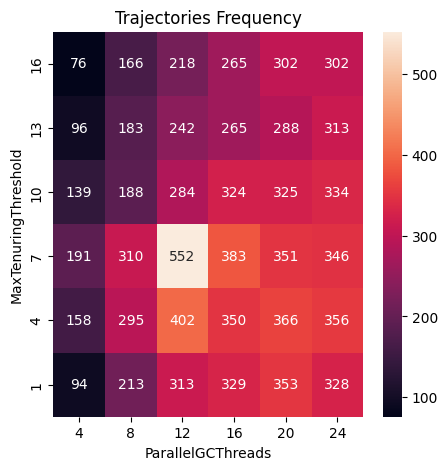

In [9]:
from util.plots_util import plot_dataset, plot_goal_heatmap

plot_dataset(replay_buffer)
# plot_goal_heatmap(env)

## Agent Training

In [15]:
def train(_agent, _env_train, _env_val, 
          steps: int = 5000, 
          use_wandb: bool = False,
          eval_interval: int=100):
    """
    Train reinforcement learning agent and evaluate
    performance on a separate environment.
    """
    seed = 42
    total_return = 0.0

    _env_train.reset()
    _env_val.reset()
    
    _agent.train = common.function(_agent.train)
    _agent.train_step_counter.assign(0)
    _agent.initialize()
    time_step = _env_val.reset()
    policy_state = _agent.collect_policy.get_initial_state(_env_train.batch_size)

    loss = []
    observations = []

    rewards = []
    # avg_reward = compute_avg_return(_env_val, _agent.policy, num_episodes=50)
    # rewards = [avg_reward]

    for _ in tqdm(range(steps)):

        # Add new trajectory to buffer with agent's collect_policy.
        for _ in range(collect_steps_per_iteration):
            traj = collect_step(_env_train, _agent.collect_policy, replay_buffer)
            replay_buffer.add_batch(traj)

        # Update the dataset.
        _dataset = replay_buffer.as_dataset(
            num_parallel_calls=3, 
            sample_batch_size=batch_size,
            num_steps=n_step_update + 1, 
            single_deterministic_pass=False).prefetch(3)

        _iterator = iter(_dataset)

        # Iterate through the dataset, get a trajectory to learn.
        experience, _ = next(_iterator)
        train_loss = _agent.train(experience)

        # Calculate a reward on evaluation environment
        policy_step = _agent.policy.action(time_step, seed=seed)
        time_step = _env_val.step(policy_step.action)
        rwd = time_step.reward.numpy()[0]
        obs = time_step.observation.numpy()[0]
        total_return += rwd # Calculate a sum of rewards

        step = _agent.train_step_counter.numpy()

        if step % eval_interval == 0:
            # avg_reward = total_return / eval_interval
            # avg_reward = compute_avg_return(_env_val, _agent.policy, num_episodes=50)
            avg_reward = compute_avg_return_episodic(_env_val, _agent.policy, num_episodes=50)
            total_return = 0.0 # reset

            loss.append(train_loss.loss.numpy())
            observations.append(obs)
            rewards.append(avg_reward)

            # wandb logger for tuning hyperparameters
            if use_wandb:
                wandb.log({'loss': train_loss.loss, 'reward': avg_reward})

            print(f"step = {step}: loss = {train_loss.loss}, reward = {avg_reward}")
    
    return loss, observations, rewards

In [16]:
# num_steps = 20000
num_steps = 5000
loss, observations, rewards = train(agent, train_env, eval_env, steps = num_steps)

  0%|          | 0/5000 [00:00<?, ?it/s]

  2%|▏         | 102/5000 [00:11<30:13,  2.70it/s]

step = 100: loss = 0.15524066984653473, reward = 11.989802360534668


  4%|▍         | 202/5000 [00:23<30:39,  2.61it/s]

step = 200: loss = 0.0840921476483345, reward = 11.978577613830566


  6%|▌         | 301/5000 [00:35<40:04,  1.95it/s]

step = 300: loss = 0.15571193397045135, reward = 11.968605995178223


  8%|▊         | 401/5000 [00:46<36:09,  2.12it/s]

step = 400: loss = 0.1489579826593399, reward = 11.96014404296875


 10%|█         | 502/5000 [00:57<26:22,  2.84it/s]

step = 500: loss = 0.17857547104358673, reward = 11.952518463134766


 12%|█▏        | 602/5000 [01:09<26:31,  2.76it/s]

step = 600: loss = 0.1740656942129135, reward = 11.945574760437012


 14%|█▍        | 702/5000 [01:21<26:07,  2.74it/s]

step = 700: loss = 0.14874297380447388, reward = 11.939336776733398


 16%|█▌        | 801/5000 [01:33<29:46,  2.35it/s]

step = 800: loss = 0.19293558597564697, reward = 11.933523178100586


 18%|█▊        | 901/5000 [01:45<33:39,  2.03it/s]

step = 900: loss = 0.1699562519788742, reward = 11.928423881530762


 20%|██        | 1001/5000 [01:57<28:50,  2.31it/s]

step = 1000: loss = 0.2110428363084793, reward = 11.923633575439453


 22%|██▏       | 1101/5000 [02:10<33:08,  1.96it/s]

step = 1100: loss = 0.2395891398191452, reward = 11.919183731079102


 24%|██▍       | 1201/5000 [02:23<28:38,  2.21it/s]

step = 1200: loss = 0.14192913472652435, reward = 11.915157318115234


 26%|██▌       | 1301/5000 [02:36<30:05,  2.05it/s]

step = 1300: loss = 0.11254499107599258, reward = 11.911437034606934


 28%|██▊       | 1401/5000 [02:49<30:22,  1.97it/s]

step = 1400: loss = 0.21589238941669464, reward = 11.907937049865723


 30%|███       | 1501/5000 [03:01<29:18,  1.99it/s]

step = 1500: loss = 0.2813939154148102, reward = 11.904711723327637


 32%|███▏      | 1602/5000 [03:15<21:02,  2.69it/s]

step = 1600: loss = 0.10100006312131882, reward = 11.901647567749023


 34%|███▍      | 1701/5000 [03:28<29:37,  1.86it/s]

step = 1700: loss = 0.16122904419898987, reward = 11.898828506469727


 36%|███▌      | 1802/5000 [03:40<19:17,  2.76it/s]

step = 1800: loss = 0.09726575016975403, reward = 11.896161079406738


 38%|███▊      | 1902/5000 [03:53<18:46,  2.75it/s]

step = 1900: loss = 0.07150854915380478, reward = 11.893571853637695


 40%|████      | 2002/5000 [04:04<18:52,  2.65it/s]

step = 2000: loss = 0.19435246288776398, reward = 11.891142845153809


 42%|████▏     | 2101/5000 [04:18<36:02,  1.34it/s]

step = 2100: loss = 0.14243020117282867, reward = 11.888810157775879


 44%|████▍     | 2202/5000 [04:29<16:49,  2.77it/s]

step = 2200: loss = 0.10555724054574966, reward = 11.88662338256836


 46%|████▌     | 2302/5000 [04:42<19:14,  2.34it/s]

step = 2300: loss = 0.062179457396268845, reward = 11.884521484375


 48%|████▊     | 2401/5000 [04:55<18:42,  2.32it/s]

step = 2400: loss = 0.26490846276283264, reward = 11.882529258728027


 50%|█████     | 2501/5000 [05:08<19:53,  2.09it/s]

step = 2500: loss = 0.12100610882043839, reward = 11.880606651306152


 52%|█████▏    | 2602/5000 [05:18<07:44,  5.16it/s]

step = 2600: loss = 0.11991270631551743, reward = 4.122697830200195


 54%|█████▍    | 2701/5000 [05:29<07:50,  4.88it/s]

step = 2700: loss = 0.10168454796075821, reward = 4.121768951416016


 56%|█████▌    | 2802/5000 [05:39<06:19,  5.80it/s]

step = 2800: loss = 0.18007953464984894, reward = 4.12086820602417


 58%|█████▊    | 2901/5000 [05:50<06:02,  5.79it/s]

step = 2900: loss = 0.10984056442975998, reward = 4.120026111602783


 60%|██████    | 3001/5000 [06:02<06:09,  5.41it/s]

step = 3000: loss = 0.13239674270153046, reward = 4.1191253662109375


 62%|██████▏   | 3101/5000 [06:12<05:53,  5.37it/s]

step = 3100: loss = 0.25683507323265076, reward = 4.118366241455078


 64%|██████▍   | 3202/5000 [06:22<04:20,  6.91it/s]

step = 3200: loss = 0.16931742429733276, reward = 4.117570877075195


 66%|██████▌   | 3301/5000 [06:33<04:55,  5.76it/s]

step = 3300: loss = 0.1502377837896347, reward = 4.1168317794799805


 68%|██████▊   | 3401/5000 [06:42<05:00,  5.32it/s]

step = 3400: loss = 0.09375574439764023, reward = 4.1161417961120605


 70%|███████   | 3501/5000 [06:52<04:17,  5.82it/s]

step = 3500: loss = 0.10210023075342178, reward = 4.115473747253418


 72%|███████▏  | 3600/5000 [07:04<04:06,  5.69it/s]

step = 3600: loss = 0.1640099138021469, reward = 4.114868640899658


 74%|███████▍  | 3702/5000 [07:14<03:11,  6.79it/s]

step = 3700: loss = 0.13673539459705353, reward = 4.114370346069336


 76%|███████▌  | 3802/5000 [07:24<03:09,  6.31it/s]

step = 3800: loss = 0.1478184312582016, reward = 4.113801002502441


 78%|███████▊  | 3900/5000 [07:36<03:18,  5.55it/s]

step = 3900: loss = 0.193813756108284, reward = 4.113282680511475


 80%|████████  | 4001/5000 [07:46<02:55,  5.71it/s]

step = 4000: loss = 0.1775280088186264, reward = 4.112780570983887


 82%|████████▏ | 4101/5000 [07:56<02:50,  5.27it/s]

step = 4100: loss = 0.1389385312795639, reward = 4.112266540527344


 84%|████████▍ | 4201/5000 [08:08<02:28,  5.39it/s]

step = 4200: loss = 0.3191501796245575, reward = 4.111846923828125


 86%|████████▌ | 4301/5000 [08:19<02:49,  4.13it/s]

step = 4300: loss = 0.17619948089122772, reward = 4.111364364624023


 88%|████████▊ | 4402/5000 [08:29<01:39,  6.03it/s]

step = 4400: loss = 0.24093137681484222, reward = 4.110896110534668


 90%|█████████ | 4501/5000 [08:40<02:54,  2.87it/s]

step = 4500: loss = 0.09015157073736191, reward = 4.11052942276001


 92%|█████████▏| 4602/5000 [08:51<01:15,  5.27it/s]

step = 4600: loss = 0.2335057258605957, reward = 4.110128879547119


 94%|█████████▍| 4702/5000 [09:00<00:43,  6.82it/s]

step = 4700: loss = 0.23590831458568573, reward = 4.1097235679626465


 96%|█████████▌| 4801/5000 [09:11<00:32,  6.06it/s]

step = 4800: loss = 0.18132583796977997, reward = 4.109341144561768


 98%|█████████▊| 4901/5000 [09:23<00:17,  5.65it/s]

step = 4900: loss = 0.21041379868984222, reward = 4.108991622924805


100%|██████████| 5000/5000 [09:32<00:00,  8.73it/s]

step = 5000: loss = 0.12847886979579926, reward = 4.108616352081299


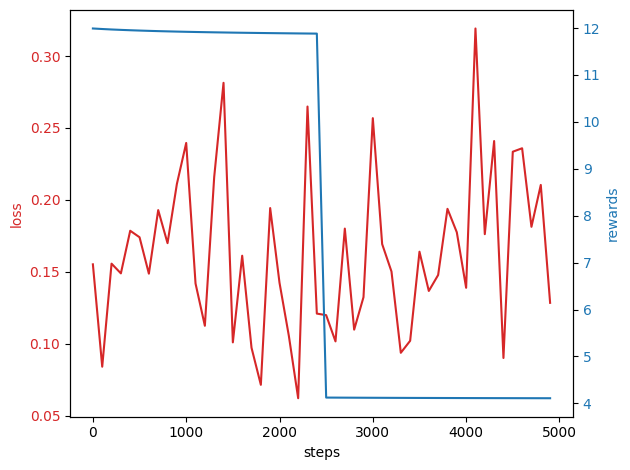

In [17]:
fig, ax1 = plt.subplots()

steps = [step for step in range(0, num_steps, 100)]
color = 'tab:red'
ax1.set_xlabel('steps')
ax1.set_ylabel('loss', color=color)
ax1.plot(steps, loss, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('rewards', color=color)  # we already handled the x-label with ax1
ax2.plot(steps, rewards, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [ ]:
plt.plot(rewards, label="Rewards")
plt.xlabel('Step')
plt.legend()
plt.show()

NameError: name 'plt' is not defined

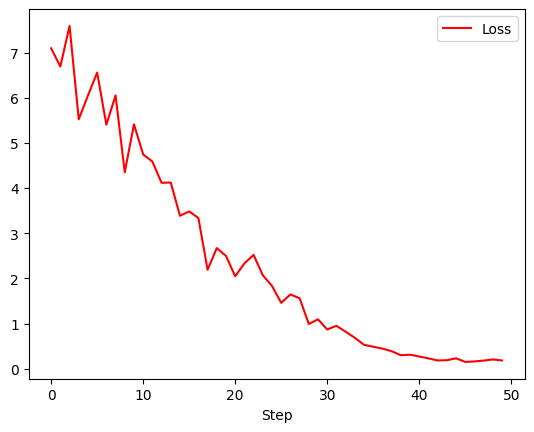

In [12]:
plt.plot(loss, label="Loss", c='r')
# plt.plot(rewards, label="Rewards")
plt.xlabel('Step')
plt.legend()
plt.show()

Save to checkpoint.

In [ ]:
# train_checkpointer.save(global_step)

# WandB

In [9]:
# Set this to True when you want to run hyperparameter tuning
hyperparameter_tuning = True

def main():
    run = wandb.init(config = config)
    
    agent_args = {
        "q_network":            get_q_net(action_spec, fc_layer_params),
        "optimizer":            tf.compat.v1.train.AdamOptimizer(
                                    learning_rate=run.config.learning_rate),
        "n_step_update":        n_step_update, 
        "td_errors_loss_fn":    tf.keras.losses.MeanSquaredError(),
        "epsilon_greedy":       run.config.epsilon_greedy,
        "target_update_period": run.config.target_update_period,
        "gamma":                run.config.gamma,
        "gradient_clipping":    1,
        "train_step_counter":   tf.compat.v1.train.get_or_create_global_step(),
    }
        
    _agent = dqn_agent.DqnAgent(
        time_step_spec,
        action_spec,
        **agent_args
    )

    loss, _, rewards = train(_agent, train_env, eval_env, steps = 5000, use_wandb = True)
    
    wandb.log({'avg_loss': np.mean(loss), 'avg_reward': np.mean(rewards)})

    del _agent
    return

# Define sweep config
sweep_configuration = {
    'method': 'random',
    'name': 'rl_greed',
    "metric": {
        "name" : "avg_reward",
        "goal": "maximize"
    },
    "parameters" : {
        "learning_rate": {
            "min": 0.0001,
            "max": 0.01
        },
        "epsilon_greedy": {'values': [0.1, 0.3, 0.5, 0.7, 0.9]},
        "target_update_period": {'values': [1, 10, 100, 1000, 10000]},
        "gamma": {'values': [0.1, 0.3, 0.5, 0.7, 0.9]},
    },
    'run_cap' : 32
}

if hyperparameter_tuning:
    ! export WANDB_NOTEBOOK_NAME="main.ipynb"
    # Initialize sweep by passing in config. (Optional) Provide a name of the project.
    sweep_id = wandb.sweep(sweep=sweep_configuration, project=PROJECT_NAME,)

    # Start sweep job.
    wandb.agent(sweep_id, function=main)

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Create sweep with ID: srh8mikx
Sweep URL: https://wandb.ai/cold-machines/Reinforcement%20Learning%20%28DQN%29%20-%20JVM-GC/sweeps/srh8mikx


wandb: Agent Starting Run: 86wuplng with config:
wandb: 	epsilon_greedy: 0.7
wandb: 	gamma: 0.1
wandb: 	learning_rate: 0.009081865474555018
wandb: 	target_update_period: 100
ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: valeriia-sakovskaia (cold-machines). Use `wandb login --relogin` to force relogin


  0%|          | 0/5000 [00:00<?, ?it/s]

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
  2%|▏         | 101/5000 [00:16<18:44,  4.36it/s]

step = 100: loss = 0.051988594233989716, reward = -0.05968308076262474


  4%|▍         | 201/5000 [00:32<17:56,  4.46it/s]

step = 200: loss = 0.04959993064403534, reward = -0.05968308076262474


  6%|▌         | 301/5000 [00:48<17:17,  4.53it/s]

step = 300: loss = 0.05310416966676712, reward = -0.05968308076262474


  8%|▊         | 401/5000 [01:04<21:05,  3.64it/s]

step = 400: loss = 0.07190939784049988, reward = -0.05968308076262474


 10%|█         | 501/5000 [01:20<16:40,  4.50it/s]

step = 500: loss = 0.06140190362930298, reward = -0.05968308076262474


 12%|█▏        | 601/5000 [01:36<16:26,  4.46it/s]

step = 600: loss = 0.07814410328865051, reward = -0.05968308076262474


 14%|█▍        | 701/5000 [01:53<16:30,  4.34it/s]

step = 700: loss = 0.05395403504371643, reward = -0.05968308076262474


 16%|█▌        | 801/5000 [02:08<15:39,  4.47it/s]

step = 800: loss = 0.05778862535953522, reward = -0.05968308076262474


 18%|█▊        | 901/5000 [02:25<14:59,  4.56it/s]

step = 900: loss = 0.05692460760474205, reward = -0.05968308076262474


 20%|██        | 1001/5000 [02:41<15:17,  4.36it/s]

step = 1000: loss = 0.059485163539648056, reward = -0.05968308076262474


 22%|██▏       | 1101/5000 [02:57<14:36,  4.45it/s]

step = 1100: loss = 0.07164233177900314, reward = -0.05968308076262474


 24%|██▍       | 1201/5000 [03:14<14:20,  4.41it/s]

step = 1200: loss = 0.04963871091604233, reward = -0.05968308076262474


 26%|██▌       | 1301/5000 [03:30<14:23,  4.28it/s]

step = 1300: loss = 0.05595877766609192, reward = -0.05968308076262474


 28%|██▊       | 1401/5000 [03:46<13:25,  4.47it/s]

step = 1400: loss = 0.05879542976617813, reward = -0.05968308076262474


 30%|███       | 1501/5000 [04:02<12:52,  4.53it/s]

step = 1500: loss = 0.06716286391019821, reward = -0.05968308076262474


 32%|███▏      | 1601/5000 [04:18<13:14,  4.28it/s]

step = 1600: loss = 0.05800986662507057, reward = -0.05968308076262474


 34%|███▍      | 1701/5000 [04:35<12:29,  4.40it/s]

step = 1700: loss = 0.06368903815746307, reward = -0.05968308076262474


 36%|███▌      | 1801/5000 [04:51<12:38,  4.22it/s]

step = 1800: loss = 0.05840213596820831, reward = -0.05968308076262474


 38%|███▊      | 1901/5000 [05:07<11:47,  4.38it/s]

step = 1900: loss = 0.06790091097354889, reward = -0.05968308076262474


 40%|████      | 2001/5000 [05:24<11:03,  4.52it/s]

step = 2000: loss = 0.05456307530403137, reward = -0.05968308076262474


 42%|████▏     | 2101/5000 [05:39<10:43,  4.51it/s]

step = 2100: loss = 0.05199477821588516, reward = -0.05968308076262474


 44%|████▍     | 2201/5000 [05:56<10:51,  4.30it/s]

step = 2200: loss = 0.046316057443618774, reward = -0.05968308076262474


 46%|████▌     | 2301/5000 [06:12<09:51,  4.56it/s]

step = 2300: loss = 0.0451720654964447, reward = -0.05968308076262474


 48%|████▊     | 2401/5000 [06:28<09:59,  4.34it/s]

step = 2400: loss = 0.05063679814338684, reward = -0.05968308076262474


 50%|█████     | 2501/5000 [06:44<09:13,  4.51it/s]

step = 2500: loss = 0.05682305246591568, reward = -0.05968308076262474


 52%|█████▏    | 2601/5000 [07:01<08:57,  4.46it/s]

step = 2600: loss = 0.057316817343235016, reward = -0.05968308076262474


 54%|█████▍    | 2701/5000 [07:17<08:40,  4.42it/s]

step = 2700: loss = 0.06233186647295952, reward = -0.05968308076262474


 56%|█████▌    | 2801/5000 [07:34<08:08,  4.50it/s]

step = 2800: loss = 0.030263567343354225, reward = -0.05968308076262474


 58%|█████▊    | 2901/5000 [07:49<07:45,  4.51it/s]

step = 2900: loss = 0.12275780737400055, reward = -0.05968308076262474


 60%|██████    | 3001/5000 [08:06<07:35,  4.39it/s]

step = 3000: loss = 0.0640171468257904, reward = -0.05968308076262474


 62%|██████▏   | 3101/5000 [08:22<07:06,  4.45it/s]

step = 3100: loss = 0.06743437051773071, reward = -0.05968308076262474


 64%|██████▍   | 3201/5000 [08:39<07:00,  4.27it/s]

step = 3200: loss = 0.07279805094003677, reward = -0.05968308076262474


 66%|██████▌   | 3301/5000 [08:55<06:22,  4.45it/s]

step = 3300: loss = 0.03942070156335831, reward = -0.05968308076262474


 68%|██████▊   | 3401/5000 [09:12<06:25,  4.14it/s]

step = 3400: loss = 0.06413926929235458, reward = -0.05968308076262474


 70%|███████   | 3501/5000 [09:27<05:42,  4.38it/s]

step = 3500: loss = 0.04303019493818283, reward = -0.05968308076262474


 72%|███████▏  | 3601/5000 [09:43<05:13,  4.46it/s]

step = 3600: loss = 0.0326034352183342, reward = -0.05968308076262474


 74%|███████▍  | 3701/5000 [10:00<04:56,  4.38it/s]

step = 3700: loss = 0.06070145219564438, reward = -0.05968308076262474


 76%|███████▌  | 3801/5000 [10:16<04:34,  4.37it/s]

step = 3800: loss = 0.05568353831768036, reward = -0.05968308076262474


 78%|███████▊  | 3901/5000 [10:33<04:09,  4.40it/s]

step = 3900: loss = 0.0671439915895462, reward = -0.05968308076262474


 80%|████████  | 4001/5000 [10:49<03:42,  4.49it/s]

step = 4000: loss = 0.07973361760377884, reward = -0.05968308076262474


 82%|████████▏ | 4101/5000 [11:06<03:38,  4.11it/s]

step = 4100: loss = 0.05744113028049469, reward = -0.05968308076262474


 84%|████████▍ | 4201/5000 [11:22<03:00,  4.44it/s]

step = 4200: loss = 0.04437218979001045, reward = -0.05968308076262474


 86%|████████▌ | 4301/5000 [11:37<02:34,  4.51it/s]

step = 4300: loss = 0.06655722111463547, reward = -0.05968308076262474


 88%|████████▊ | 4401/5000 [11:55<02:13,  4.49it/s]

step = 4400: loss = 0.054657574743032455, reward = -0.05968308076262474


 90%|█████████ | 4501/5000 [12:10<01:51,  4.49it/s]

step = 4500: loss = 0.05559392273426056, reward = -0.05968308076262474


 92%|█████████▏| 4601/5000 [12:27<01:32,  4.31it/s]

step = 4600: loss = 0.062225304543972015, reward = -0.05968308076262474


 94%|█████████▎| 4678/5000 [12:39<00:49,  6.51it/s]

### Restore checkpoint

In [ ]:
def test(policy, test_env, num_episodes: int=10000):
    rewards = []
    log_interval = 100
    time_step = test_env.reset()
    total_return = 0.0
    for i in tqdm(range(10000)):
        policy_state = policy.action(time_step)
        time_step = test_env.step(policy_state.action)
        reward = time_step.reward.numpy()[0]
        total_return += reward # Calculate a sum of rewards

        if i % log_interval == 0:
            # avg_return = compute_avg_return(eval_env, agent.policy, 10)
            avg_return = total_return / eval_interval
            print('step = {0}: Average reward = {1:.5f}'.format(step, avg_return))
            rewards.append(avg_return)
            total_return = 0.0 # reset
    return rewards

# test(agent.policy, test_env)

# Episodic Memory

In [70]:
from util import episodic_memory
from sklearn.mixture import GaussianMixture

def embedding_similarity(x1, x2):
    assert x1.shape[0] == x2.shape[0]
    epsilon = 1e-6

    # Inner product between the embeddings in x1
    # and the embeddings in x2.
    s = np.sum(x1 * x2, axis=-1)

    s = s / (np.linalg.norm(x1, axis=-1) * np.linalg.norm(x2, axis=-1) + epsilon)
    return 0.5 * (s + 1.0)


In [66]:
observations = replay_buffer.gather_all()[1].numpy().squeeze()
actions = replay_buffer.gather_all()[2].numpy().squeeze()
size = 15

memory_buffer = np.array([[*observations[i], actions[i]] for i in range(size)])

In [82]:
memory_buffer.squeeze().shape

(15, 3)

In [76]:
gm = GaussianMixture(n_components=memory_buffer.shape[1])

In [77]:
gm.fit(memory_buffer)

GaussianMixture(n_components=3)

In [84]:
gm.predict_proba([[7, 12, 0]])

array([[0.00000000e+00, 9.99999917e-01, 8.31505676e-08]])

In [62]:
df = pd.read_csv(f"avrora_synthetic_saved_states.csv")
print("df size:", len(df))
states  = {}
size = 15 
# replay_buffer.capacity
for i in range(size):
    states [i] = {"args": [df["MaxTenuringThreshold"].values[i], df["ParallelGCThreads"].values[i]], "goal": df["Average GC Pause"].values[i]}

# memory_buffer = np.array([states[i]["args"] for i in states.keys()])
memory_buffer = np.array([[*observations[i], actions[i]] for i in range(size)])
print(memory_buffer)

df size: 36
[[ 4 24  3]
 [ 4 24  1]
 [ 7 24  2]
 [ 7 20  2]
 [ 7 16  3]
 [ 7 20  0]
 [ 4 20  3]
 [ 4 24  2]
 [ 4 20  2]
 [ 4 16  2]
 [ 4 12  1]
 [ 7 12  0]
 [ 4 12  1]
 [ 7 12  3]
 [ 7 16  2]]


In [92]:
perf_states = {}
perf_states[0] = {"args": [7, 12], "goal": 0.47, "count": 1} 
saved_states = [perf_states[i]["args"] for i in perf_states.keys()]
flags = [7, 12]
if flags in saved_states:
    for i in perf_states.keys():
        """ 
        If current state is stored in a cache,
        update the state goal value.
        """
        if flags == perf_states[i]["args"]:
            goal = perf_states[i]["goal"]
            perf_states[i]["count"] += 1

print(perf_states)

{0: {'args': [7, 12], 'goal': 0.47, 'count': 2}}


In [97]:
for i in perf_states.keys():
    if [7, 12] == perf_states[i]["args"]:
        print(perf_states[i]["count"])

2


In [15]:
(1 + 0.01)**(-1/4)

0.9975155087566253

In [63]:
observation = np.array([[7, 12, 3]] * size)
similarity = embedding_similarity(observation, memory_buffer[:size])
similarity

array([0.96638056, 0.96084794, 0.98113075, 0.98760397, 0.99632883,
       0.97980966, 0.97269349, 0.9640097 , 0.97034901, 0.97857303,
       0.98519848, 0.98873447, 0.98519848, 1.        , 0.99432438])

In [48]:
traj

Trajectory(
{'action': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>,
 'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.5], dtype=float32)>,
 'next_step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1], dtype=int32)>,
 'observation': <tf.Tensor: shape=(1, 2), dtype=int64, numpy=array([[ 7, 12]])>,
 'policy_info': (),
 'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-1.], dtype=float32)>,
 'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>})

In [47]:
import math

math.log(0.00001)

-11.512925464970229

In [7]:
observations = replay_buffer.gather_all()[1].numpy().squeeze()
print(len(observations))
# for i in range(100):
#     print(f"[{i}] {observations[i]}")

print(f"[{0}] {observations[0]}")
print(f"[{10}] {observations[10]}")
print(f"[{15}] {observations[15]}")
print(f"[{2}] {observations[2]}")
print(f"[{4}] {observations[4]}")

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=True)` instead.


Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=True)` instead.


10000
[0] [ 7 12]
[10] [ 7 16]
[15] [4 8]
[2] [10  8]
[4] [ 4 12]


In [10]:
observation_shape = [2]
memory = episodic_memory.EpisodicMemory(
    observation_shape=observation_shape,
    observation_compare_fn=embedding_similarity,
    capacity=150)

memory.add(observation=observations[0], info=dict())
memory.add(observation=observations[10], info=dict())
memory.add(observation=observations[15], info=dict())
memory.add(observation=observations[2], info=dict())
memory.add(observation=observations[4], info=dict())

In [35]:
similarities = memory.similarity(observations[0])
print(similarities)

[1.         0.99556546 0.99941687 1.         1.        ]


0.4711529108389231

In [56]:
new_df = pd.read_csv(f"avrora_synthetic_saved_states.csv")
perf_states  = {}
flags = [7, 12]
def synthethic_run(flags):
    assert len(flags) == 2, "Amount of flags is not 2"
    row = new_df[((new_df["MaxTenuringThreshold"] == flags[0]) & (new_df["ParallelGCThreads"] == flags[1]))].values.squeeze()
    goal = row[2]
    return goal

synthethic_run(flags)

0.4711529108389231